In [1]:
import numpy as np
import torch
from scipy.io import loadmat
import math
import matplotlib.pyplot as plt

#### Loading matrices

In [2]:
mat1 = loadmat('ForceVec_1225.mat')
mat2 = loadmat('Stiffness_1225.mat')

In [3]:
ForceVec = torch.from_numpy(mat1['B']).float()
stiffness = torch.from_numpy(mat2['K']).float()

In [4]:
dim = int(mat1['B'].shape[0])

#### Seed

In [5]:
def seed_lib():
    # RANDOM_SEED = 50
    # np.random.seed(RANDOM_SEED)
    # torch.manual_seed(RANDOM_SEED)
    return 

#### inverse_matrix

In [6]:
%%time
true_solution = torch.linalg.inv(stiffness) @ ForceVec

CPU times: user 612 ms, sys: 156 ms, total: 768 ms
Wall time: 893 ms


#### steepest descent

In [7]:
def steepest_descent(A,b,x,for_plot = False):

    if (A != torch.t(A)).any():
        raise ValueError('Matrix A needs to be symmetric positive definite (SPD)')
    
    residual = b - A @ x
    num_iter = 0
    residual_norm_init = (residual.T @ residual)
    residual_norm_curr = residual_norm_init
    epsilon = 1e-10
    while (residual_norm_curr > (epsilon)*residual_norm_init):

        temp = A @ residual
        alpha = residual_norm_curr/(residual.T @ temp)
        x = x + (alpha * residual)

        if num_iter%10 == 0:
            residual = b - A @ x

        else:
            residual = residual - (alpha * temp)

        residual_norm_curr = (residual.T @ residual)
        num_iter += 1

    return x,num_iter

In [8]:
%%time
seed_lib()
starting_x = torch.rand(dim,1)
x_steepest,iter_steepest = steepest_descent(stiffness,ForceVec,starting_x)

CPU times: user 14 s, sys: 500 ms, total: 14.5 s
Wall time: 7.52 s


In [9]:
iter_steepest

7446

In [10]:
torch.dist(x_steepest,true_solution,2)

tensor(7.1268)

#### complexity_of_SD

In [11]:
lambda_max = float(torch.lobpcg(stiffness,k = 1,largest = True)[0])
lambda_min = float(torch.lobpcg(stiffness,k = 1,largest = False)[0])
print(lambda_max,lambda_min)
condition_number = int(abs(lambda_max/lambda_min))
print(condition_number)

/home/lohith/chida/environments/basic/lib/python3.7/site-packages/torch/_lobpcg.py:946: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:1672.)
  Rinv = torch.triangular_solve(Id, R, upper=True).solution


9.979934692382812 0.0047704544849693775
2092


In [12]:
omega_max = (iter_steepest-1)/(iter_steepest+1)
print(omega_max)
epsilon = 1e-10
steepest_max_iter = math.log(1/(epsilon))/math.log((condition_number+1)/(condition_number-1))
print(int(steepest_max_iter))

0.9997314354773734
24085


$ O(max(sparsity,n)*steepest\_max\_iter) = O(n*steepest\_max\_iter) $

$ steepest\_max\_iter = \frac{ln(1/ϵ)}{ln\big(\frac{κ+1}{κ-1}\big)} $

$ κ = \frac{λ_{max}}{λ_{min}} $

#### Conjugate_gradient

In [13]:
def conjugate_gradient(A,b,x,n):

    if (A != torch.t(A)).any():
        raise ValueError('Matrix A needs to be symmetric positive definite (SPD)')

    r = b - A @ x
    d = r
    num_iter = 0
    residual_norm_init = (r.T @ r)
    residual_norm_curr = residual_norm_init
    epsilon = 1e-10

    while (residual_norm_curr > (epsilon)*residual_norm_init and num_iter < n):

        p = A @ d
        alpha = residual_norm_curr/(d.T @ p)
        x = x + alpha * d
        if num_iter%10 == 0:
            r = b - A @ x
        else:
            r = r - alpha * p
        temp = residual_norm_curr
        residual_norm_curr = r.T @ r
        beta = residual_norm_curr/temp
        d = r + beta * d
        num_iter = num_iter + 1

    return x,num_iter

In [14]:
%%time
seed_lib()
x_conjugate,iter_conjugate = conjugate_gradient(stiffness,ForceVec,starting_x,dim)

CPU times: user 388 ms, sys: 16 ms, total: 404 ms
Wall time: 247 ms


In [15]:
iter_conjugate

133

In [16]:
torch.dist(x_conjugate,true_solution,2)

tensor(0.1638)

#### Complexity_of_CG

In [17]:
epsilon = 1e-10
temp = math.sqrt(condition_number)
conjugate_max_iter = int(math.log(2/(epsilon))/math.log((temp+1)/(temp-1)))
print(conjugate_max_iter)
omega = ((temp-1)/(temp+1))
print(omega)

542
0.9572086212299215


$O(max(sparsity,n)*conjugate\_max\_iter) = O(n*conjugate\_max\_iter)$

$conjugate\_max\_iter = min\Big(\frac{ln(2/ϵ)}{ln\big(\frac{\sqrt{k}+1}{\sqrt{k} -1}\big)},n \Big)$

$κ = \frac{λ_{max}}{λ_{min}}$

#### Comparision_between_SD_CG

In [18]:
def comp_steepest_descent(A,b,x,epsilon = 1e-10):

    if (A != torch.t(A)).any():
        raise ValueError('Matrix A needs to be symmetric positive definite (SPD)')

    residual = b - A @ x
    num_iter = 0
    acc_sd = {}
    residual_norm_init = (residual.T @ residual)
    residual_norm_curr = residual_norm_init
    epsilon = 1e-10
    while (residual_norm_curr > (epsilon)*residual_norm_init):

        temp = A @ residual
        alpha = residual_norm_curr/(residual.T @ temp)
        x = x + (alpha * residual)

        if num_iter%10 == 0:
            residual = b - A @ x
            acc_sd[num_iter] = torch.dist(x,true_solution,2)

        else:
            residual = residual - (alpha * temp)

        residual_norm_curr = (residual.T @ residual)
        num_iter += 1

    return x,num_iter,acc_sd

def comp_conjugate_gradient(A,b,x,n,epsilon = 1e-10):

    if (A != torch.t(A)).any():
        raise ValueError('Matrix A needs to be symmetric positive definite (SPD)')

    r = b- A @ x
    d = r
    num_iter = 0
    residual_norm_init = (r.T @ r)
    residual_norm_curr = residual_norm_init
    acc_cg = {}
    while (residual_norm_curr > (epsilon)*residual_norm_init and num_iter < n):
        p = A @ d
        alpha = residual_norm_curr/(d.T @ p)
        x = x + alpha * d
        if num_iter%10 == 0:
            r = b - A @ x
            acc_cg[num_iter] = torch.dist(x,true_solution,2)
        else:
            r = r - alpha * p
        temp = residual_norm_curr
        residual_norm_curr = r.T @ r
        beta = residual_norm_curr/temp
        d = r + beta * d
        num_iter = num_iter + 1

    return x,num_iter,acc_cg


In [19]:
x_sd,iter_sd,acc_sd = comp_steepest_descent(stiffness,ForceVec,starting_x)
x_cg,iter_cg,acc_cg = comp_conjugate_gradient(stiffness,ForceVec,starting_x,dim)

In [20]:
final_steepest_norm = torch.dist(x_sd,true_solution,2)
final_conjugate_norm = torch.dist(x_cg,true_solution,2)

In [21]:
print(f'Norm difference of final solution obtained by steepest_descent after {iter_sd} iterations is {final_steepest_norm}')
print(f'Norm difference of final solution obtained by conjugate_gradient after {iter_cg} iterations is {final_conjugate_norm}')

Norm difference of final solution obtained by steepest_descent after 7446 iterations is 7.126845836639404
Norm difference of final solution obtained by conjugate_gradient after 133 iterations is 0.1637696474790573


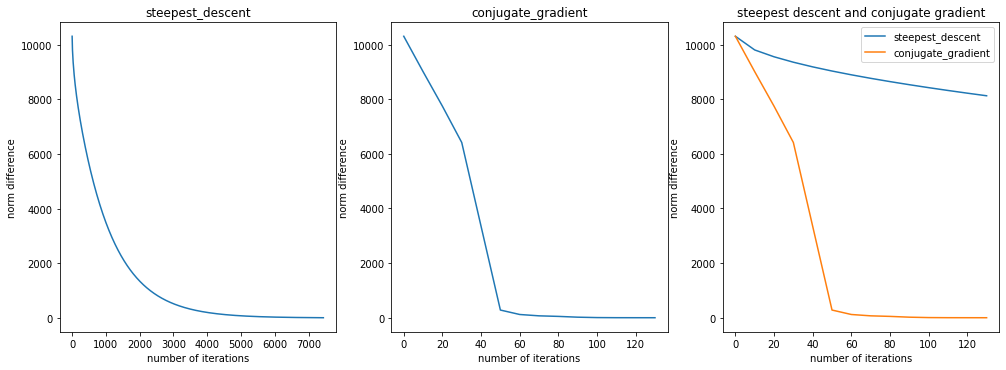

In [22]:
figure, axis = plt.subplots(1,3)
x_sd,y_sd = zip(*sorted(acc_sd.items()))
axis[0].plot(x_sd,y_sd)
axis[0].set_title("steepest_descent")
x_cg,y_cg = zip(*sorted(acc_cg.items()))
axis[1].plot(x_cg,y_cg)
axis[1].set_title('conjugate_gradient')
axis[2].plot(x_cg,y_sd[:len(x_cg)])
axis[2].plot(x_cg,y_cg)
axis[2].legend(['steepest_descent','conjugate_gradient'],loc = "upper right")
axis[2].set_title("steepest descent and conjugate gradient")
figure.subplots_adjust(hspace = 10,wspace = 0.2)
plt.subplots_adjust(top = 1.2,right = 2.3)
plt.setp(axis,xlabel = 'number of iterations')
plt.setp(axis,ylabel = 'norm difference')
plt.show()


#### Gibbs Sampling

In [23]:
def normal(mean,var):
    seed_lib()
    return mean +  math.sqrt(var) * float(torch.randn(1))

In [24]:
sigma = torch.linalg.inv(stiffness)

In [25]:
torch.count_nonzero(stiffness)/(1225 * 1225)

tensor(0.0040)

In [26]:
def gibbs_sampler(N,num_iter,start = torch.zeros(dim), lr = 1):
    iter = num_iter
    x = torch.zeros((iter*N,N))
    for j in range(iter):
        for i in range(N):
            temp = torch.cat((start[:i],start[i+1:]))
            var = 1/stiffness[i][i]
            intermediate = (torch.cat((stiffness[i][:i],stiffness[i][i+1:]))/(-stiffness[i][i]))
            mean = intermediate @ temp.T
            start[i] = lr * normal(mean,var)
            x[j*N+i] = start
    return x


def sigma_convergence(N,x,sigma,samples,num_iter,start = torch.zeros(dim),bf = 10):
    acc_sigma_convergence = {}
    sum = torch.zeros((N,N))
    burn_in = num_iter//bf
    count = 0
    visited = 0
    if samples == 0:
        sum = sum + torch.outer(start,start.T)
        return torch.linalg.norm(sum - sigma)

    for j in range(num_iter):
        for i in range(N):
            sum = sum  + torch.outer(x[j*N+i],x[j*N+i].T)/(samples)
            count += 1
            if count == samples:
                visited = 1
                break
            if i == 0:
                acc_sigma_convergence[j*N + i] = torch.linalg.norm(sum - sigma)

        if visited == 1:
            break
    dist = torch.linalg.norm(sum-sigma)
    return dist,acc_sigma_convergence

def jump_sigma_convergence(N,x,sigma,samples,num_iter,bf = 10):
    acc_jump_sigma_convergence = {}
    jump_sum = torch.zeros((N,N))
    burn_in = num_iter//bf
    count = 0
    for j in range(burn_in,num_iter):
        jump_sum = jump_sum + torch.outer(x[j*N],x[j*N].T)/samples
        count += 1
        acc_jump_sigma_convergence[j*N] = torch.linalg.norm(jump_sum - sigma)
        if count == samples:
            break
    dist = torch.linalg.norm(jump_sum - sigma)
    return dist,acc_jump_sigma_convergence 

def conj_sigma_convergence(N,x,A,sigma,samples,num_iter,bf = 10):
    acc_conj_sigma_convergence = {}
    val = torch.zeros((N,N))
    burn_in = num_iter//bf
    count = 0
    for j in range(burn_in,num_iter):
            val = val  + torch.outer(x[j*N],x[j*N].T)/(x[j*N][None,:] @ A @ x[j*N][:,None])
            count += 1
            acc_conj_sigma_convergence[j*N] = torch.linalg.norm(((val/count) * N ) - sigma)
            if count == samples:
                break
    val = (val/samples)*N
    dist = torch.linalg.norm(val - sigma)
    return dist,acc_conj_sigma_convergence

In [27]:
num_iter = 10
start = torch.zeros(dim)
x = gibbs_sampler(dim ,num_iter,start,0.1)
bf = 2
norm,acc_sigma_convergence = sigma_convergence(dim , x, sigma, num_iter * dim, num_iter,bf)
print(f'Plane Gibbs sampling norm with {dim} samples = {norm}')

jump_norm,acc_jump_sigma_convergence = jump_sigma_convergence(dim , x, sigma, num_iter, num_iter,bf)
print(f'Jump Gibbs sampling norm with {dim} samples = {jump_norm}')

conj_norm,acc_conj_sigma_convergence = conj_sigma_convergence(dim , x, stiffness, sigma, num_iter, num_iter,bf)
print(f'conjugate norm with {dim} samples = {conj_norm}')


/home/lohith/chida/environments/basic/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2318.)
  if __name__ == "__main__":


Plane Gibbs sampling norm with 1225 samples = 236.1416473388672
Jump Gibbs sampling norm with 1225 samples = 236.14500427246094
conjugate norm with 1225 samples = 243.1108856201172


#### Generating plots comparing the three convergence methods of Gibbs Sampler

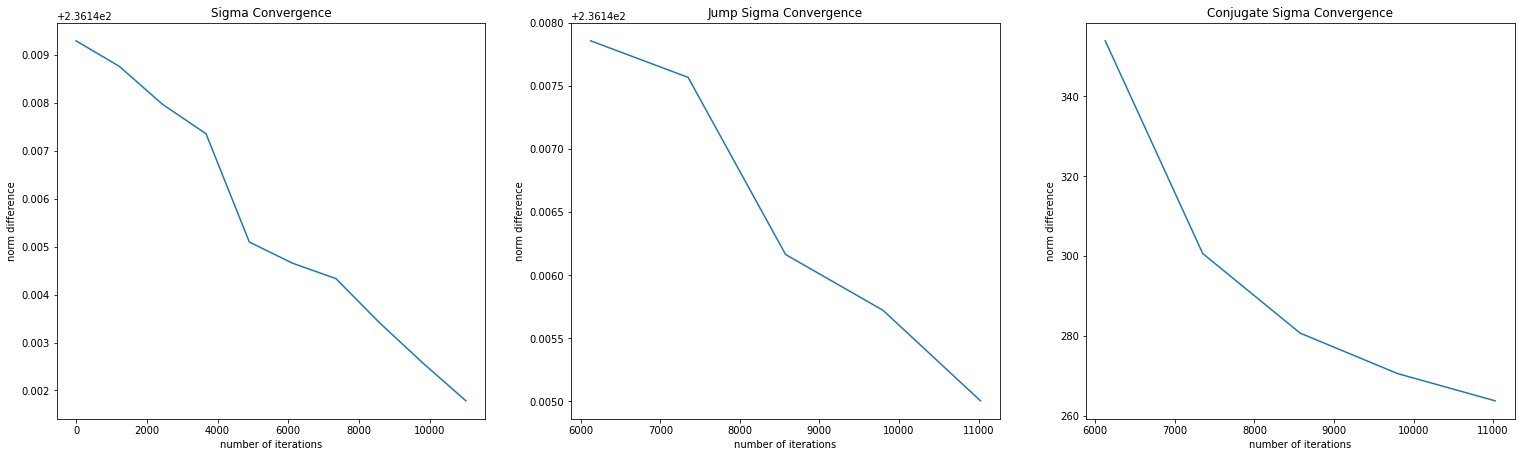

In [28]:
figure, axis = plt.subplots(1,3)
x_sd,y_sd = zip(*sorted(acc_sigma_convergence.items()))
axis[0].plot(x_sd,y_sd)
axis[0].set_title("Sigma Convergence")
x_cg,y_cg = zip(*sorted(acc_jump_sigma_convergence.items()))
axis[1].plot(x_cg,y_cg)
axis[1].set_title('Jump Sigma Convergence')
x_cg,y_cg = zip(*sorted(acc_conj_sigma_convergence.items()))
axis[2].plot(x_cg,y_cg)
axis[2].set_title('Conjugate Sigma Convergence')
figure.subplots_adjust(hspace = 8,wspace = 0.2)
plt.subplots_adjust(top = 1.5,right = 3.5)
plt.setp(axis,xlabel = 'number of iterations')
plt.setp(axis,ylabel = 'norm difference')
plt.savefig('comparision.png', bbox_inches='tight')


#### Sampling from N(0,inv(A)) using CG

In [29]:
def cg_sampler(A,b,x,n):

    if (A != torch.t(A)).any():
        raise ValueError('Matrix A needs to be symmetric positive definite (SPD)')

    r = b - A @ x
    p = r
    d = p.T @ A @ p
    y = x
    list_y = y.T
    # print(list_y)
    num_iter = 0
    residual_norm_init = (r.T @ r)
    residual_norm_curr = residual_norm_init
    epsilon = 1e-20

    while (torch.linalg.norm(r) > epsilon and num_iter < n):

        temp = (r.T @ r)
        gamma = temp/d
        x = x + gamma * p
        z = int(torch.randn(1))
        y = y + (z/(d ** 0.5)) * p
        list_y = torch.cat((list_y,y.T),0)
        r = r - gamma * (A @ p)
        residual_norm_curr = r.T @ r
        beta = -(residual_norm_curr/temp)
        p = r - beta * p
        d = p.T @ A @ p
        num_iter = num_iter + 1

    return x,y,num_iter,list_y

In [30]:
x = torch.randn(1, 3)
s = x
print(s)
for i in range(2):
    s = torch.cat((s, x), 0)
print(s)

tensor([[0.8707, 1.6043, 0.5243]])
tensor([[0.8707, 1.6043, 0.5243],
        [0.8707, 1.6043, 0.5243],
        [0.8707, 1.6043, 0.5243]])


In [31]:
%%time
x_cg_samp,y_cg_samp,iter_cg_samp,list_y = cg_sampler(stiffness,ForceVec,starting_x,dim)

CPU times: user 2.65 s, sys: 200 ms, total: 2.85 s
Wall time: 1.69 s


In [32]:
iter_cg_samp

513

In [33]:
torch.dist(x_cg_samp,true_solution,2)

tensor(0.0431)

In [34]:
inverse = torch.linalg.inv(stiffness)

In [35]:
list_y.size()

torch.Size([514, 1225])

In [36]:
sum = 0
burn_in = list_y.size()[0]//10
n = list_y.size()[0] - burn_in
for i in list_y[burn_in:]:
    sum += torch.outer(i,i.T)/n
    break

In [37]:
temp = abs(sum - inverse)
print(temp.size())
print(torch.max(temp),torch.min(temp),torch.mean(temp))

torch.Size([1225, 1225])
tensor(3.1489) tensor(1.7884e-07) tensor(0.1228)


In [38]:
((1225 * 1225) ** 0.5 ) * abs(torch.mean(temp))

tensor(150.4878)

In [39]:
torch.dist(sum,inverse,2)

tensor(235.1963)